# Hourly energy demand generation and weather

This is from the similarly named dataset on [Kaggle](https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather).

There are two data sets, ```energy``` and ```weather```.

## Data Dictionary

For the ```energy``` dataset:

- ```time```: Datetime index localized to CET
- ```generation biomass```: biomass generation in MW
- ```generation fossil coal-derived gass```: coal/lignite generation in MW
- ```generattion fossil coal-derived gass```: coal/gas generation in MW
- ```generation fossil gass```: gas generation in MW
- ```generation fossil hard coal```: coal generation in MW
- ```generation fossil oil```: oil generation in MW
- ```generation fossil oil share```: shale oil generation in MW
- ```generation fossil peat```: peat generation in MW
- ```generation geothermal```: geothermal generatio in MW
- ```generation hydro pumped storage aggregated```: hydro1 generation in MW
- ```generation hydro pumped storage consumption```: hydro 2 generation in MW
- ```generation hydro run-of-river and poundage```: hydro 3 generation in MW
- ```generation hydro water reservoir```: hydro 4 generatio in MW
- ```generation marine```: sea generation in MW
- ```generation nuclear```: nuclear generation in MW
- ```generation other```: other generation in MW
- ```generation other renewable```: other renewable generation in MW
- ```generation solar```: solar generatio in MW
- ```generation waste```: waste generation in MW
- ```generation wind offshore```: wind offshore generation in MW
- ```generation wind onshore```: wind onshore generation in MW
- ```forecast solar day ahead```: forecasted solar generation
- ```forecast wind offshore eday ahead```: forecasted offshore wind generation
- ```forecast wind onshore day ahead```: forecasted onshore wind generation
- ```total load forecast```: forecasted electrical demand
- ```total load actual```: actual electrical demand
- ```price day ahead```: forecasted price in EUR/MWh
- ```price actual```: price in EUR/MWh


And for the ```weather``` dataset:



- ```dt_iso```: datetime index localized to CET
- ```city_name```: name of city
- ```temp```: in Kelvin

- ```temp_min```: minimun in K
- ```temp_max```: maximum in K
- ```pressure```: pressure in hPa
- ```humidity```: humidity in percent
- ```wind_speed```: wind speed in m/s
- ```wind_deg```: wind direction
- ```rain_1h```: rain in last hour in mm
- ```rain_3h```: rain in last 3 hours in mm
- ```snow_3h```: snow in last 3 hours in mm
- ```clouds_all```: cloud cover in percentage
- ```weather_id```: code used to describe weather

- ```weather_main```: short description of current weather
- ```weather_description```: long description of current weather
- ```weather_icon```: weather icon code for website




In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-white')
plt.rc('figure', autolayout=True)
plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=14,
    linewidth=4
    )


%matplotlib inline


## Load and Preliminarly Explore the Data

In [2]:
energy = pd.read_csv('energy_dataset.csv')
weather = pd.read_csv('weather_features.csv')

First, let's explore the ```energy``` dataset.

In [3]:
energy.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [4]:
energy.shape

(35064, 29)

In [5]:
energy.isnull().sum()

time                                               0
generation biomass                                19
generation fossil brown coal/lignite              18
generation fossil coal-derived gas                18
generation fossil gas                             18
generation fossil hard coal                       18
generation fossil oil                             19
generation fossil oil shale                       18
generation fossil peat                            18
generation geothermal                             18
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption       19
generation hydro run-of-river and poundage        19
generation hydro water reservoir                  18
generation marine                                 19
generation nuclear                                17
generation other                                  18
generation other renewable                        18
generation solar                              

In [6]:
energy_cols = energy.columns.tolist()

for x in energy_cols:
    print(x,': ', energy[x].nunique())

time :  35064
generation biomass :  423
generation fossil brown coal/lignite :  956
generation fossil coal-derived gas :  1
generation fossil gas :  8297
generation fossil hard coal :  7266
generation fossil oil :  321
generation fossil oil shale :  1
generation fossil peat :  1
generation geothermal :  1
generation hydro pumped storage aggregated :  0
generation hydro pumped storage consumption :  3311
generation hydro run-of-river and poundage :  1684
generation hydro water reservoir :  7029
generation marine :  1
generation nuclear :  2388
generation other :  103
generation other renewable :  78
generation solar :  5331
generation waste :  262
generation wind offshore :  1
generation wind onshore :  11465
forecast solar day ahead :  5356
forecast wind offshore eday ahead :  0
forecast wind onshore day ahead :  11332
total load forecast :  14790
total load actual :  15127
price day ahead :  5747
price actual :  6653


In [7]:
print(len(energy_cols[0]))

4


In [8]:
energy.dtypes

time                                            object
generation biomass                             float64
generation fossil brown coal/lignite           float64
generation fossil coal-derived gas             float64
generation fossil gas                          float64
generation fossil hard coal                    float64
generation fossil oil                          float64
generation fossil oil shale                    float64
generation fossil peat                         float64
generation geothermal                          float64
generation hydro pumped storage aggregated     float64
generation hydro pumped storage consumption    float64
generation hydro run-of-river and poundage     float64
generation hydro water reservoir               float64
generation marine                              float64
generation nuclear                             float64
generation other                               float64
generation other renewable                     float64
generation

The ```energy``` data set has 29 columns and 35064 rows. All columns are float except for the ```time``` column. We should convert that column to a datetime object so we can more easily use the times. Most columns have less than 20 missing values. However, two columns (```generation hydro pumped storage aggregated``` and ```forecast wind offshore eday ahead```) are missing all values. We should remove those columns. A few additional columns have only a single unique value (typically 0). We will remove these columns (```generation fossil coal-derived gas```, ```generation fossil oil shale```, ```generation fossil peat```, ```generation geothermal```, ```generation marine```, and ```generation wind offshore```) because they do not provide any helpful information.

Finally, we note that the column names have spaces between the words. To make it easier for our coding, we'll replace the spaces with underscores.

Data cleaning tasks for the ```energy``` data set:

- convert the ```time``` column to a datetime object
- remove ```generation hydro pumped storage aggregated``` and ```forecast wind offshore eday ahead```
- remove ```generation fossil coal-derived gas```, ```generation fossil oil shale```, ```generation fossil peat```, ```generation geothermal```, ```generation marine```, and ```generation wind offshore```
- replace spaces in column names with underscore

In [9]:
weather.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [10]:
weather.shape

(178396, 17)

In [11]:
weather.isnull().sum()

dt_iso                 0
city_name              0
temp                   0
temp_min               0
temp_max               0
pressure               0
humidity               0
wind_speed             0
wind_deg               0
rain_1h                0
rain_3h                0
snow_3h                0
clouds_all             0
weather_id             0
weather_main           0
weather_description    0
weather_icon           0
dtype: int64

In [12]:
weather_cols = weather.columns.tolist()

for x in weather_cols:
    print(x,': ', weather[x].nunique())

dt_iso :  35064
city_name :  5
temp :  20743
temp_min :  18553
temp_max :  18591
pressure :  190
humidity :  100
wind_speed :  36
wind_deg :  361
rain_1h :  7
rain_3h :  89
snow_3h :  66
clouds_all :  97
weather_id :  38
weather_main :  12
weather_description :  43
weather_icon :  24


In [13]:
weather['city_name'].value_counts()

Madrid        36267
Bilbao        35951
Seville       35557
 Barcelona    35476
Valencia      35145
Name: city_name, dtype: int64

In [14]:
weather.dtypes

dt_iso                  object
city_name               object
temp                   float64
temp_min               float64
temp_max               float64
pressure                 int64
humidity                 int64
wind_speed               int64
wind_deg                 int64
rain_1h                float64
rain_3h                float64
snow_3h                float64
clouds_all               int64
weather_id               int64
weather_main            object
weather_description     object
weather_icon            object
dtype: object

The ```weather``` data set has 17 columns and 178396 rows. It is very clean. There are no null values and every column has multiple unique values. There are data included for five cities: Madrid, Bilbao, Seville, Barcelona, and Valencia. Barcelona has a leading space at the beginning that we'll have to be careful with. Each city is included a different number of times, so we'll have to sort out why that is. There are 35064 unique datetimes. That matches the number in the ```energy``` dataset. Hopefully all of these match, but we'll have to check first. The majority of the columns are numeric types. The ```weather_main```, ```weather_description```, and ```weather_icon``` are all objects. These could be useful as a general description of the type of weather, so we will keep all of these for now.  

Data cleaning tasks for the ```weather``` data set:
- convert ```dt_iso``` to a datetime object


## Data Cleaning

Now that we have explored and identified what we need to do for data cleaning, let's implement it for both data sets.

In [15]:
# we will start with the energy dataset

In [16]:

#- convert the ```time``` column to a datetime object
#- remove ```generation hydro pumped storage aggregated``` and ```forecast wind offshore eday ahead```
#- remove ```generation fossil coal-derived gas```, ```generation fossil oil shale```, ```generation fossil peat```, ```generation geothermal```, ```generation marine```, and ```generation wind offshore```
#- replace spaces in column names with underscore

energy['time'] = pd.to_datetime(energy['time'])

columns_to_remove = ['generation hydro pumped storage aggregated','forecast wind offshore eday ahead',
                    'generation fossil coal-derived gas','generation fossil oil shale',
                    'generation fossil peat','generation geothermal',
                    'generation marine','generation wind offshore']

energy_clean = energy.drop(columns_to_remove,axis=1)

energy_clean.columns = energy_clean.columns.str.replace(' ','_')

In [17]:
energy_clean.head()

,time,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run-of-river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,...,generation_other_renewable,generation_solar,generation_waste,generation_wind_onshore,forecast_solar_day_ahead,forecast_wind_onshore_day_ahead,total_load_forecast,total_load_actual,price_day_ahead,price_actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,73.0,49.0,196.0,6378.0,17.0,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,71.0,50.0,195.0,5890.0,16.0,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,73.0,50.0,196.0,5461.0,8.0,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,75.0,50.0,191.0,5238.0,2.0,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,74.0,42.0,189.0,4935.0,9.0,4861.0,21785.0,20264.0,38.41,56.04


In [18]:
# and now we can clean the weather dataset

weather['dt_iso'] = pd.to_datetime(weather['dt_iso'])

In [19]:
weather.dtypes

dt_iso                  object
city_name               object
temp                   float64
temp_min               float64
temp_max               float64
pressure                 int64
humidity                 int64
wind_speed               int64
wind_deg                 int64
rain_1h                float64
rain_3h                float64
snow_3h                float64
clouds_all               int64
weather_id               int64
weather_main            object
weather_description     object
weather_icon            object
dtype: object

## Merging Data

First, we need to find out if the times in both data sets are the same. The times in ```weather``` are repeated, so we need to extract the unique times first.  

After that, we want to fold the ```weather``` data set into the ```energy``` data set. We want to separate out the ```weather``` data by ```city```, then add each relevant column. We should prepend the name of each city to the feature on the new data set, such as ```madrid_temp```. 

In [20]:
weather_unique_times = weather['dt_iso'].unique()
energy_unique_times = energy_clean['time'].unique()

test_times = weather_unique_times == energy_unique_times

In [21]:
np.size(test_times) - np.count_nonzero(test_times)

0

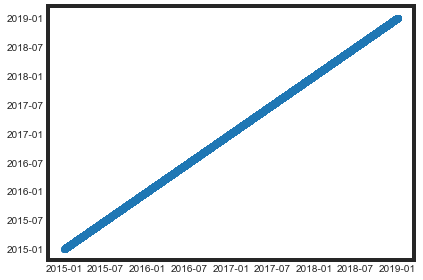

In [22]:
plt.scatter(weather_unique_times,energy_unique_times)
plt.show()

In [23]:
city_names = ['Madrid','Bilbao','Seville',' Barcelona','Valencia']

# let's create an iteration variable so we don't overwrite our data
# we'll use this instead of looking for Madrid so our code is more flexible
iteration = np.linspace(1,len(city_names),num=len(city_names))


for city, it in zip(city_names,iteration):
    # extract only the city for this iteration
    city_extract = weather[weather['city_name'] == city]
    
    # alter the names of the columns to suffix the name of the city
    if city == ' Barcelona':
        city = 'Barcelona' # remove the leading space
    city_suffice = '_' + city
    city_extract = city_extract.add_suffix(city_suffice)
    city_time_col = 'dt_iso_' + city
    
    # merge the dataframes
    if it == 1:
        full_df = energy_clean.merge(city_extract,
                                    left_on='time',right_on=city_time_col,
                                    how='left',suffixes=(None,city))
    else:
        full_df = full_df.merge(city_extract,
                                    left_on='time',right_on=city_time_col,
                                    how='left',suffixes=(None,city))
        

full_df.head()


,time,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run-of-river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,...,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,rain_3h_Valencia,snow_3h_Valencia,clouds_all_Valencia,weather_id_Valencia,weather_main_Valencia,weather_description_Valencia,weather_icon_Valencia
0,2015-01-01 00:00:00+01:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [24]:
full_df.columns.tolist()

['time',
 'generation_biomass',
 'generation_fossil_brown_coal/lignite',
 'generation_fossil_gas',
 'generation_fossil_hard_coal',
 'generation_fossil_oil',
 'generation_hydro_pumped_storage_consumption',
 'generation_hydro_run-of-river_and_poundage',
 'generation_hydro_water_reservoir',
 'generation_nuclear',
 'generation_other',
 'generation_other_renewable',
 'generation_solar',
 'generation_waste',
 'generation_wind_onshore',
 'forecast_solar_day_ahead',
 'forecast_wind_onshore_day_ahead',
 'total_load_forecast',
 'total_load_actual',
 'price_day_ahead',
 'price_actual',
 'dt_iso_Madrid',
 'city_name_Madrid',
 'temp_Madrid',
 'temp_min_Madrid',
 'temp_max_Madrid',
 'pressure_Madrid',
 'humidity_Madrid',
 'wind_speed_Madrid',
 'wind_deg_Madrid',
 'rain_1h_Madrid',
 'rain_3h_Madrid',
 'snow_3h_Madrid',
 'clouds_all_Madrid',
 'weather_id_Madrid',
 'weather_main_Madrid',
 'weather_description_Madrid',
 'weather_icon_Madrid',
 'dt_iso_Bilbao',
 'city_name_Bilbao',
 'temp_Bilbao',
 'temp

In [25]:
# let's check some of the times to ensure they match up. We'll pick a random integer, 
# then display those times in the dataframe

starting_row = np.random.randint(0,full_df.shape[0])
length = 10 # we'll look at 10 rows at a time

print(full_df.iloc[starting_row:starting_row+length][['time','dt_iso_Valencia']])

#print(starting_row)

                            time            dt_iso_Valencia
34294  2018-07-31 13:00:00+02:00  2018-07-31 13:00:00+02:00
34295  2018-07-31 14:00:00+02:00  2018-07-31 14:00:00+02:00
34296  2018-07-31 15:00:00+02:00  2018-07-31 15:00:00+02:00
34297  2018-07-31 16:00:00+02:00  2018-07-31 16:00:00+02:00
34298  2018-07-31 17:00:00+02:00  2018-07-31 17:00:00+02:00
34299  2018-07-31 18:00:00+02:00  2018-07-31 18:00:00+02:00
34300  2018-07-31 18:00:00+02:00  2018-07-31 18:00:00+02:00
34301  2018-07-31 19:00:00+02:00  2018-07-31 19:00:00+02:00
34302  2018-07-31 19:00:00+02:00  2018-07-31 19:00:00+02:00
34303  2018-07-31 20:00:00+02:00  2018-07-31 20:00:00+02:00


In [26]:
times_cities = ['dt_iso_Valencia','dt_iso_Barcelona','dt_iso_Madrid','dt_iso_Seville','dt_iso_Bilbao']

for x in times_cities:
    time_check = full_df['time'] == full_df[x]
    print(x,np.size(time_check) - np.count_nonzero(time_check))

dt_iso_Valencia 0
dt_iso_Barcelona 0
dt_iso_Madrid 0
dt_iso_Seville 0
dt_iso_Bilbao 0


In [27]:
city_names = ['Madrid','Bilbao','Seville',' Barcelona','Valencia']
iteration = np.linspace(1,len(city_names),num=len(city_names))

#print(iteration)

for city, it in zip(city_names,iteration):
    print(city,it)

Madrid 1.0
Bilbao 2.0
Seville 3.0
 Barcelona 4.0
Valencia 5.0


Finally, let's drop some of the redundant column names to finalize our data set. 

In [28]:
full_df.columns.tolist()

['time',
 'generation_biomass',
 'generation_fossil_brown_coal/lignite',
 'generation_fossil_gas',
 'generation_fossil_hard_coal',
 'generation_fossil_oil',
 'generation_hydro_pumped_storage_consumption',
 'generation_hydro_run-of-river_and_poundage',
 'generation_hydro_water_reservoir',
 'generation_nuclear',
 'generation_other',
 'generation_other_renewable',
 'generation_solar',
 'generation_waste',
 'generation_wind_onshore',
 'forecast_solar_day_ahead',
 'forecast_wind_onshore_day_ahead',
 'total_load_forecast',
 'total_load_actual',
 'price_day_ahead',
 'price_actual',
 'dt_iso_Madrid',
 'city_name_Madrid',
 'temp_Madrid',
 'temp_min_Madrid',
 'temp_max_Madrid',
 'pressure_Madrid',
 'humidity_Madrid',
 'wind_speed_Madrid',
 'wind_deg_Madrid',
 'rain_1h_Madrid',
 'rain_3h_Madrid',
 'snow_3h_Madrid',
 'clouds_all_Madrid',
 'weather_id_Madrid',
 'weather_main_Madrid',
 'weather_description_Madrid',
 'weather_icon_Madrid',
 'dt_iso_Bilbao',
 'city_name_Bilbao',
 'temp_Bilbao',
 'temp

In [29]:
columns_to_drop = ['dt_iso_Madrid','city_name_Madrid',
                  'dt_iso_Bilbao','city_name_Bilbao',
                  'dt_iso_Seville','city_name_Seville',
                  'dt_iso_Barcelona','city_name_Barcelona',
                  'dt_iso_Valencia','city_name_Valencia']

energy_weather = full_df.drop(columns_to_drop,axis=1)

## Visualizing the Data Set

Now that we have cleaned and merged the data sets, let's do a few simple visualizations so that we can better understand the type and distributions of data we have.

In [33]:
all_columns = energy_weather.columns.tolist()

generation_columns = [x for x in all_columns if x.startswith('generation')]

generation_df = energy_weather[generation_columns]

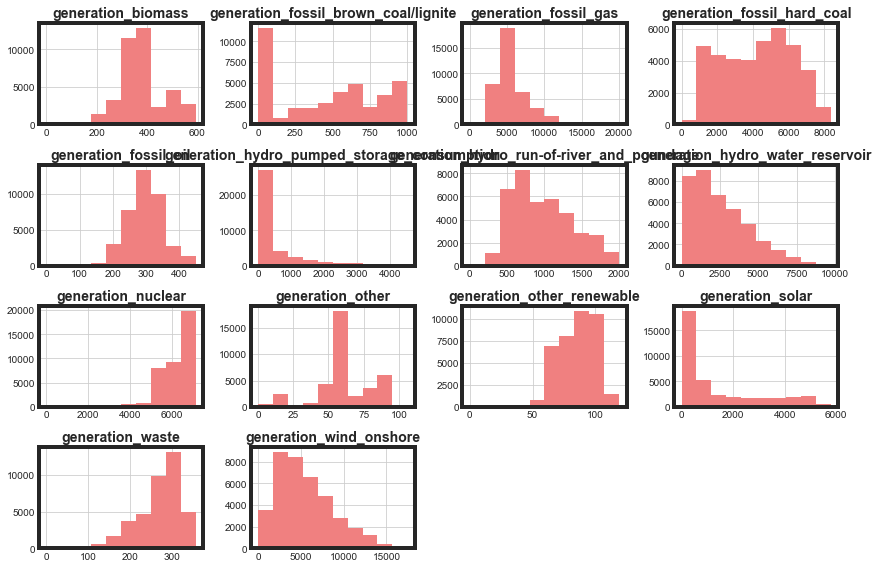

In [35]:
histograms = generation_df.hist(figsize=(12,8),color='lightcoral')


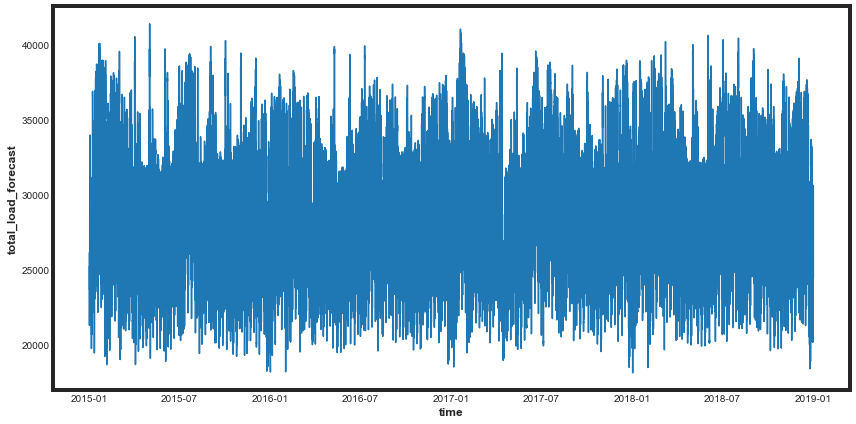

In [37]:
plt.figure(figsize=(12,6))

sns.lineplot(x='time',y='total_load_forecast',data=energy_weather)

plt.show()

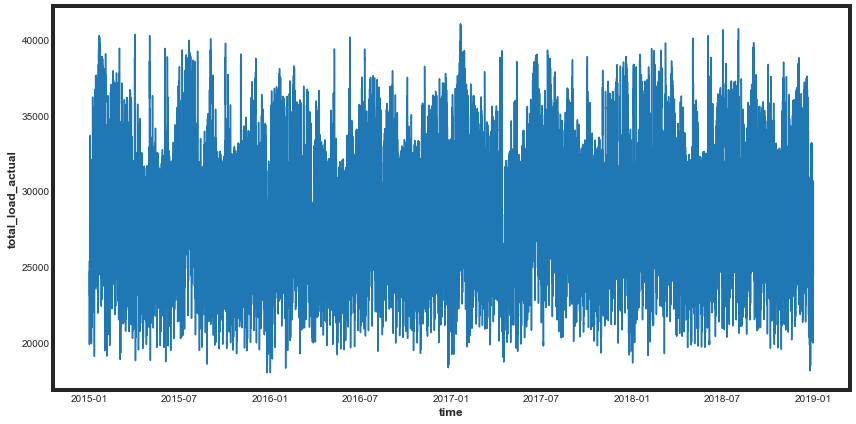

In [38]:
plt.figure(figsize=(12,6))

sns.lineplot(x='time',y='total_load_actual',data=energy_weather)

plt.show()